In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

## Data preprocession

In [82]:
df = pd.read_csv('option_train.csv', index_col=0)
df = df.sample(frac=1, random_state=21).reset_index(drop=True)
# the data for submition
df_private = pd.read_csv('option_test_nolabel.csv', index_col=0)

In [83]:
# split the data to training set and testing set
df, df_test = df[:4500].copy(), df[4500:].copy()

## EDA

#### Check Arbitrage

In [93]:
# check arbitrage
def test_no_arbitrage(df):
    """
    Test for the no-arbitrage condition based on the given inequality.
    
    :param row: pandas Series, a row of the DataFrame
    :return: bool, True if the no-arbitrage condition holds, False otherwise
    """
    
    # Calculate the present value of the strike price
    PV_K = df['K'] * np.exp(-df['r'] * df['tau'])
    
    # Calculate the two maximum values
    max_pv = max(df['S'] - PV_K, 0)
    max_s_k = max(df['S'] - df['K'], 0)
    
    # Test the inequality C > Max[S - PV(K), 0] and Max[S - PV(K), 0] ≥ Max[S - K, 0]
    return df['Value'] > max_pv >= max_s_k

# Results
print(Counter(df.apply(test_no_arbitrage, axis=1)))
print(Counter(df_test.apply(test_no_arbitrage, axis=1)))

Counter({True: 4500})
Counter({True: 500})


In [5]:
# Check for negative values in 'Value' and 'S'
negative_values_check = df[['Value', 'S']].lt(0).any()
print(negative_values_check, '\n')

# Check for non-positive time to expiration 'tau'
non_positive_tau_check = (df['tau'] <= 0).any()
print(non_positive_tau_check)

Value    False
S        False
dtype: bool 

False


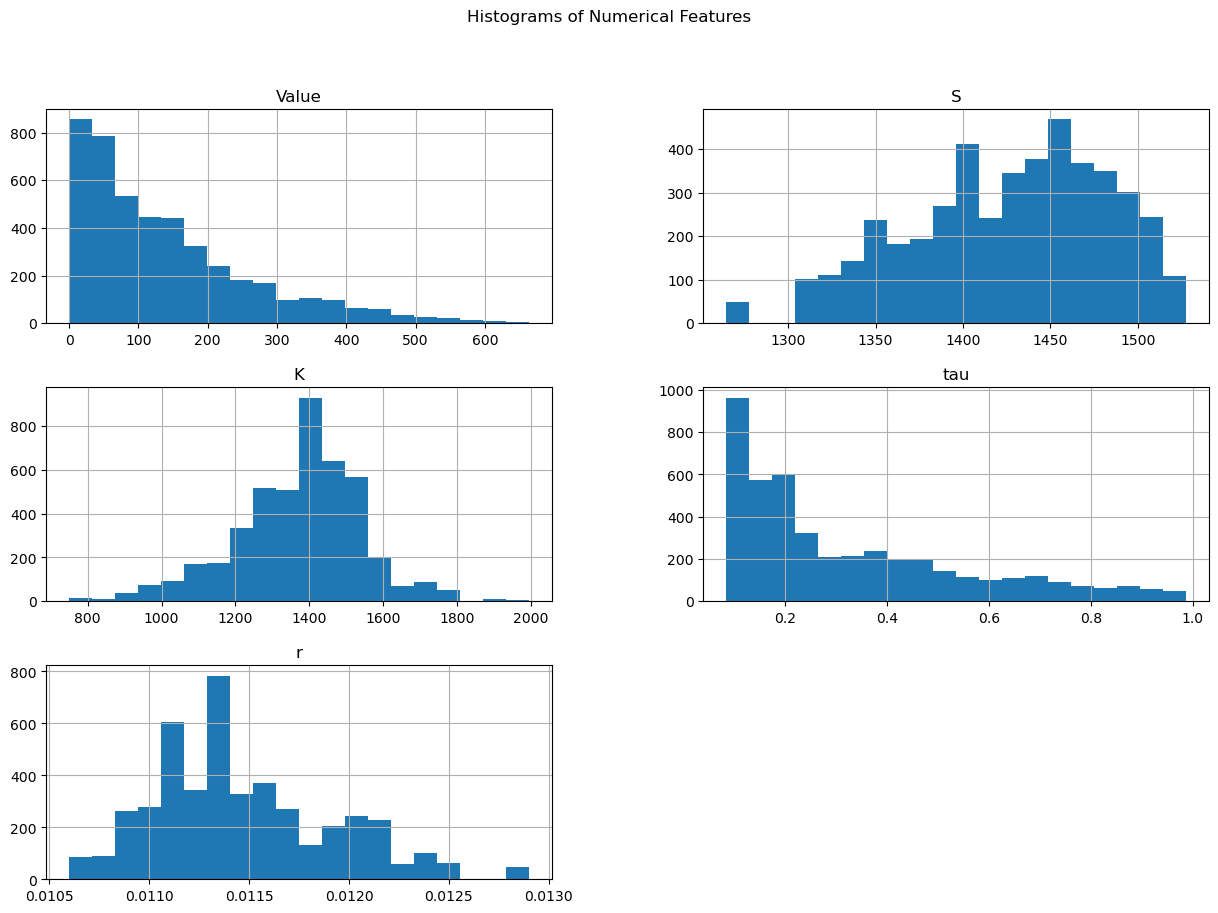

In [6]:
# Histograms for numerical features
df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

Verified by looking at the histograms: Options with more time until expiration generally have higher prices due to the greater potential for profitability

In [7]:
# Check for unique values in categorical columns and outliers or highly unusual values in numeric columns

# Categorical column: 'BS'
bs_unique_values = df['BS'].unique()

# Numeric columns: Checking for potential outliers by looking at the min, max, and any values that seem out of place
# This step was partially covered by the .describe() method, but we will also check for any values that could be considered as physically impossible or highly unlikely.
numeric_columns = ['Value', 'S', 'K', 'tau', 'r']
numeric_stats = df[numeric_columns].agg(['min', 'max', 'mean', 'std']).transpose()
 
# Checking for any negative values which would be considered erroneous in this context
negative_values = df[numeric_columns].lt(0).sum()

bs_unique_values, numeric_stats, negative_values

(array(['Under', 'Over'], dtype=object),
                min          max         mean         std
 Value     0.281250   663.250000   139.635958  124.348160
 S      1264.740000  1527.460000  1426.493527   56.006585
 K       750.000000  1995.000000  1370.661111  171.762181
 tau       0.084932     0.986301     0.326722    0.230111
 r         0.010600     0.012900     0.011469    0.000448,
 Value    0
 S        0
 K        0
 tau      0
 r        0
 dtype: int64)

Values in all columns look good. We will take another look at see if there exists unreasonbale arbitrage opportunities.

In [8]:
# Validate Against Intrinsic Value: no immediate arbitrage opportunities
condition = (df.S - df.K - df.Value) > 0
df[condition]

,Value,S,K,tau,r,BS


#### Feature augmentation

#### Standardize & convert categorical

In [9]:
# Compute new augmented columns
def feature_augmentation(df):
    df['S*K'] = df['S'] * df['K'] 
    df['S*tau'] = df['S'] * df['tau'] 
    df['S*r'] = df['S'] * df['r'] 
    df['K*tau'] = df['K'] * df['tau']
    df['K*r'] = df['K'] * df['r'] 
    df['tau*r'] = df['tau'] * df['r'] 
    df['S/K'] = df['S'] / df['K']  # Ratio of asset price to strike price
    df['r**tau'] = df['r'] ** df['tau']  # Interest rate raised to the power of time to maturity

    df['s-k'] = df['S'] - df['K']
    df['s-k/s'] = (df['S'] - df['K']) / df['S']
    df['s-k*tau'] = (df['S'] - df['K']) * df['tau']

# stardardize
def std(df):
    # Select columns to standardize (all columns except 'BS' and 'Value')
    columns_to_standardize = [col for col in df.columns if col not in ['BS', 'Value']]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler to the data and transform it, only for the selected columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# convert to numerical
def convert_to_01(df):
    df['BS'] = df['BS'].replace({'Under': 0, 'Over': 1})

In [10]:
feature_augmentation(df)
std(df)
convert_to_01(df)

feature_augmentation(df_test)
std(df_test)
convert_to_01(df_test)

feature_augmentation(df_private)
std(df_private)

In [11]:
# split X and y
# training set
y_bs_train = df['BS']
y_value_train = df['Value']
X_train = df.drop(['Value','BS'], axis=1)

# testing set, use after everything is done
y_bs_test = df_test['BS']
y_value_test = df_test['Value']
X_test = df_test.drop(['Value','BS'], axis=1)

## Feature selection

#### Feature importance method

In [12]:
# We don't use feature importance in this case because K is too important

X = X_train
y = y_bs_train
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=0.3, random_state=0)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_f, y_train_f)

# Get feature importances
feature_importances = model.feature_importances_

# Sort features by importance
sorted_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

K: 0.1414664535406928
K*r: 0.10731448305926401
S*K: 0.09583293801277486
s-k/s: 0.0846018822668875
s-k: 0.07594877963845477
S/K: 0.07585060872283594
s-k*tau: 0.07448247679256723
S*r: 0.06536097650618695
tau*r: 0.04827134267052644
S*tau: 0.04573695399705407
r**tau: 0.045498997777884055
K*tau: 0.04200887323074874
tau: 0.04198703007146364
S: 0.03250184340725138
r: 0.023136360305407735


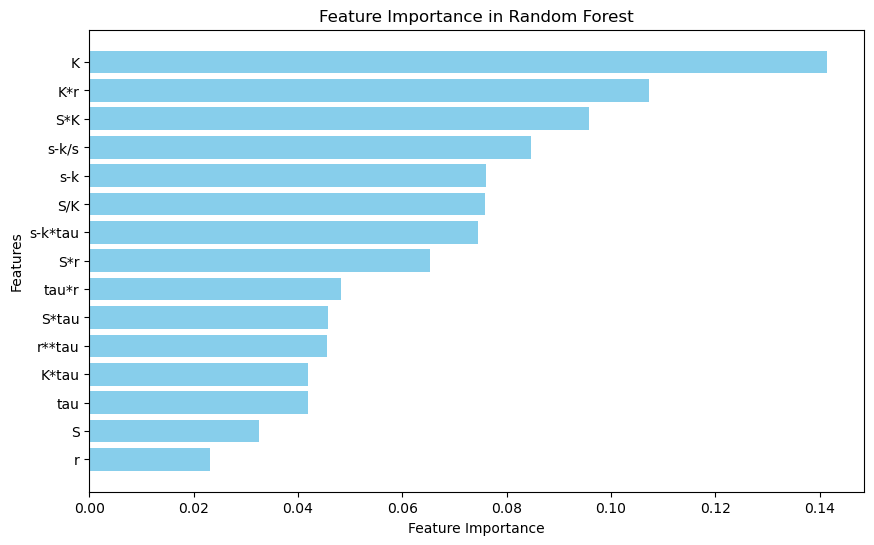

In [13]:
# visualizaiton of feature importance ranking
import matplotlib.pyplot as plt

feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# sort importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# extract feature names and importance scores
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)


plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()

#### Forward selection

In [14]:
# logistic regresion + decision tree + support vector machine
# each model runs 5 times
random_num=[0,12,38,65,87]
features_count=[]
for random_num in random_num:
    X = X_train
    y = y_bs_train
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=0.3, random_state=random_num)

    # Forward feature selection
    selected_features = []
    remaining_features = list(X.columns)
    best_accuracy = 0

    while remaining_features:
        accuracy_with_feature = {}
        for feature in remaining_features:
            model = LogisticRegression(random_state=random_num)
            model.fit(X_train_f[selected_features + [feature]], y_train_f)
            y_pred = model.predict(X_test_f[selected_features + [feature]])
            accuracy = accuracy_score(y_test_f, y_pred)
            accuracy_with_feature[feature] = accuracy

        best_feature, best_accuracy_temp = max(accuracy_with_feature.items(), key=lambda x: x[1])

        if best_accuracy_temp > best_accuracy:
            best_accuracy = best_accuracy_temp
            selected_features.append(best_feature)
            features_count.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

#    print("Selected features:", selected_features)


    # Forward feature selection
    selected_features = []
    remaining_features = list(X.columns)
    best_accuracy = 0

    while remaining_features:
        accuracy_with_feature = {}
        for feature in remaining_features:
            model = DecisionTreeClassifier(random_state=random_num)
            model.fit(X_train_f[selected_features + [feature]], y_train_f)
            y_pred = model.predict(X_test_f[selected_features + [feature]])
            accuracy = accuracy_score(y_test_f, y_pred)
            accuracy_with_feature[feature] = accuracy

        best_feature, best_accuracy_temp = max(accuracy_with_feature.items(), key=lambda x: x[1])

        if best_accuracy_temp > best_accuracy:
            best_accuracy = best_accuracy_temp
            selected_features.append(best_feature)
            features_count.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    selected_features = []
    remaining_features = list(X.columns)
    best_accuracy = 0

    while remaining_features:
        accuracy_with_feature = {}
        for feature in remaining_features:
            model = SVC(kernel='linear', random_state=random_num)  # Using a linear kernel for SVM
            model.fit(X_train_f[selected_features + [feature]], y_train_f)
            y_pred = model.predict(X_test_f[selected_features + [feature]])
            accuracy = accuracy_score(y_test_f, y_pred)
            accuracy_with_feature[feature] = accuracy

        best_feature, best_accuracy_temp = max(accuracy_with_feature.items(), key=lambda x: x[1])

        if best_accuracy_temp > best_accuracy:
            best_accuracy = best_accuracy_temp
            selected_features.append(best_feature)
            features_count.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
Counter(features_count)

Counter({'K': 15,
         'S*tau': 10,
         'S*r': 10,
         'r**tau': 9,
         's-k*tau': 3,
         'tau*r': 3,
         'K*tau': 3,
         'K*r': 2,
         'S/K': 2,
         'S': 2,
         's-k/s': 1,
         'r': 1,
         'tau': 1})

In [15]:
selected_features = [item for item, count in Counter(features_count).items() if count > 2]
selected_features

['K', 'r**tau', 'S*tau', 'S*r', 's-k*tau', 'tau*r', 'K*tau']

In [16]:
corr_matrix = df[selected_features].corr().stack()
print(corr_matrix[(abs(corr_matrix) > 0.97) & (corr_matrix != 1)])
if 'tau' in selected_features:
    selected_features.remove('tau')
if 'tau*r' in selected_features:
    selected_features.remove('tau*r')

S*tau  tau*r    0.990353
       K*tau    0.970378
tau*r  S*tau    0.990353
K*tau  S*tau    0.970378
dtype: float64


In [17]:
X_train = X_train[selected_features]
X_test = df_test[selected_features]
df_private = df_private[selected_features]

## Modeling

### Regression

In [18]:
# kfolds
kfolds = KFold(n_splits=3, random_state=0, shuffle = True)

#### Linear regression

In [19]:
lnr_reg = LinearRegression()
cv_score = cross_val_score(lnr_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'log: {round(cv_score.mean(),4)} r2: {cv_score} ')

log: 0.8657 r2: [0.865 0.861 0.871] 


#### KNN

In [20]:
# Initialize the KNeighborsRegressor model
knn_reg = KNeighborsRegressor()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': np.arange(1, 15, 2),  # Searching for the best number of neighbors
    'weights': ['uniform', 'distance'],  # You can also tune the weight function
    'p': [1, 2]  # And the power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=knn_reg, param_grid=param_grid, cv=kfolds, scoring='r2', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_value_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
best_cv_score = grid_search.best_score_
print(f'Best cross-validation R2 score: {best_cv_score:.4f}')

# The model's performance with the best parameters:
best_knn_reg = grid_search.best_estimator_
cv_score = cross_val_score(best_knn_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'KNN with best parameters - Mean CV R2 Score: {cv_score.mean():.4f}, Scores: {cv_score}')

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best parameters found:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best cross-validation R2 score: 0.9804
KNN with best parameters - Mean CV R2 Score: 0.9803, Scores: [0.981 0.98  0.98 ]


In [21]:
knn_reg = KNeighborsRegressor(**grid_search.best_params_)
cv_score = cross_val_score(knn_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'knn: {round(cv_score.mean(),4)} r2: {cv_score} ')

knn: 0.9803 r2: [0.981 0.98  0.98 ] 


#### Random forest regression

In [22]:
# Initialize the RandomForestRegressor model
rfr_reg = RandomForestRegressor(random_state=0)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 4, 6],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rfr_reg, param_grid=param_grid, cv=kfolds, scoring='r2', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_value_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
best_cv_score = grid_search.best_score_
print(f'Best cross-validation R2 score: {best_cv_score:.4f}')

# If you want to see the model's performance with the best parameters:
best_rfr_reg = grid_search.best_estimator_
cv_score = cross_val_score(best_rfr_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'Random Forest with best parameters - Mean CV R2 Score: {cv_score.mean():.4f}, Scores: {cv_score}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation R2 score: 0.9914
Random Forest with best parameters - Mean CV R2 Score: 0.9913, Scores: [0.993 0.99  0.991]


In [23]:
rfr_reg = RandomForestRegressor(random_state=0, **grid_search.best_params_)
cv_score = cross_val_score(rfr_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'rfr: {round(cv_score.mean(),4)} r2: {cv_score} ')

rfr: 0.9913 r2: [0.993 0.99  0.991] 


#### xgboost

In [24]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'subsample': [0.8, 1],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1],  # Subsample ratio of columns when constructing each tree
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=kfolds, scoring='r2', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_value_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
best_cv_score = grid_search.best_score_
print(f'Best cross-validation R2 score: {best_cv_score:.4f}')

# If you want to see the model's performance with the best parameters:
best_xgb_reg = grid_search.best_estimator_
cv_score = cross_val_score(best_xgb_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'XGB with best parameters - Mean CV R2 Score: {cv_score.mean():.4f}, Scores: {cv_score}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation R2 score: 0.9954
XGB with best parameters - Mean CV R2 Score: 0.9953, Scores: [0.996 0.995 0.995]


In [25]:
xgb_reg = xgb.XGBRegressor(**grid_search.best_params_, random_state=0)
cv_score = cross_val_score(xgb_reg, X_train, y_value_train, cv=kfolds).round(3)
print(f'xgb: {round(cv_score.mean(),4)} r2: {cv_score} ')

xgb: 0.9953 r2: [0.996 0.995 0.995] 


#### Neural network

In [26]:
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

X_scaled = X_train.values
y = y_value_train

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Initialize the list to store the results
fold_r_squared = []

# Define the Keras model for regression
def create_regression_model():
    model_reg = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)  # No activation function for regression
    ])
    model_reg.compile(optimizer='adam',
                  loss='mean_squared_error',  # MSE for regression
                  metrics=[r_squared])  # Use R-squared as the metric
    return model_reg

# Loop over the folds and train the model
for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model_reg = create_regression_model()
    model_reg.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    scores = model_reg.evaluate(X_test_fold, y_test_fold, verbose=0)
    fold_r_squared.append(scores[1])  # Append the R-squared for this fold

# Print the R-squared for each fold
print("R-squared for each fold:", fold_r_squared)

# Print the average R-squared
print("Average R-squared:", np.mean(fold_r_squared))

R-squared for each fold: [0.9148504137992859, 0.9337477087974548, 0.9175989627838135, 0.9226995706558228, 0.9378358721733093]
Average R-squared: 0.9253465056419372


### Classification

#### Logistic classification

In [27]:
log_reg = LogisticRegression(solver='liblinear',max_iter=1000)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 300],  # Example range for C
    'penalty': ['l1', 'l2']       # Penalty types to consider
}

# Set up the grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_bs_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 100, 'penalty': 'l1'}
Best score: 0.8908888888888888


In [28]:
log_clf = LogisticRegression(solver='liblinear',**grid_search.best_params_,max_iter=1000, random_state=0)
cv_score = cross_val_score(log_clf, X_train, y_bs_train, cv=kfolds).round(3)
print(f'log: {round(cv_score.mean(),4)} r2: {cv_score} ')

log: 0.8903 r2: [0.881 0.893 0.897] 


#### KNN classification

In [29]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_bs_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Best accuracy: 0.9357777777777778


In [30]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
cv_score = cross_val_score(knn_clf, X_train, y_bs_train, cv=kfolds).round(3)
print(f'knn: {round(cv_score.mean(),4)} r2: {cv_score} ')

knn: 0.9283 r2: [0.919 0.938 0.928] 


#### Random forest classification

In [31]:
# feature selection
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_bs_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy: 0.9382222222222222


In [32]:
rfr_clf = RandomForestClassifier(**grid_search.best_params_, random_state=0)
cv_score = cross_val_score(rfr_clf, X_train, y_bs_train, cv=kfolds).round(3)
print(f'rf: {round(cv_score.mean(),4)} r2: {cv_score}')

rf: 0.929 r2: [0.921 0.934 0.932]


#### xgboost

In [33]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used in update to prevents overfitting
    'n_estimators': [200, 300, 500],  # Number of gradient boosted trees
    'max_depth': [4, 5, 6],  # Maximum depth of a tree
    'min_child_weight': [1, 2],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.9, 1.0]  # Subsample ratio of the training instances
}

# Initialize the XGBClassifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_bs_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.9}
Best accuracy: 0.9415555555555557


In [34]:
xgb_clf = xgb.XGBClassifier(**grid_search.best_params_, random_state=0)
cv_score = cross_val_score(xgb_clf, X_train, y_bs_train, cv=kfolds).round(3)
print(f'xgb: {round(cv_score.mean(),4)} r2: {cv_score}')

xgb: 0.9333 r2: [0.923 0.939 0.938]


#### Neural network

In [35]:
X_scaled = X_train.values
y = y_bs_train

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Initialize the lists to store the results
fold_accuracy = []

# Define the Keras model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Loop over the folds and train the model
for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model = create_model()
    model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=32, verbose=0)

    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    fold_accuracy.append(scores[1])

# Print the accuracy for each fold
print("Accuracy for each fold:", fold_accuracy)

# Print the average accuracy
print("Average accuracy:", np.mean(fold_accuracy))

Accuracy for each fold: [0.9111111164093018, 0.9100000262260437, 0.9144444465637207, 0.9177777767181396, 0.9222221970558167]
Average accuracy: 0.9151111125946045


## Voting

### Regression

In [36]:
X_vote_train, X_vote_test, y_vote_value_train, y_vote_value_test = train_test_split(X_train, y_value_train, test_size=0.3, random_state=0)

In [37]:
def reg_models(X_train, y_train, X_test):
    global lnr_pred, knn_pred, rfr_pred, xgb_pred, ann_pred
    lnr_reg.fit(X_train, y_train)
    lnr_pred = lnr_reg.predict(X_test)
    knn_reg.fit(X_train, y_train)
    knn_pred = knn_reg.predict(X_test)
    rfr_reg.fit(X_train, y_train)
    rfr_pred = rfr_reg.predict(X_test)
    xgb_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)
    xgb_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)
    model_reg.fit(X_train, y_train,verbose=0)
    ann_pred = model_reg.predict(X_test)
    ann_pred = ann_pred.flatten()
    
reg_models(X_vote_train, y_vote_value_train, X_vote_test)

43/43 [==============================] - 0s 807us/step


#### Models accuracy

In [38]:
print('lnr:',r2_score(y_vote_value_test, lnr_pred).round(4))
print('knn:',r2_score(y_vote_value_test, knn_pred).round(4))
print('rfr:',r2_score(y_vote_value_test, rfr_pred).round(4))
print('xgb:',r2_score(y_vote_value_test, xgb_pred).round(4))
print('ann:',r2_score(y_vote_value_test, ann_pred).round(4))

lnr: 0.8647
knn: 0.981
rfr: 0.9934
xgb: 0.9951
ann: 0.94


#### Meta-model

In [39]:
# Combine training predictions
train_meta_input = np.column_stack((knn_pred,rfr_pred,xgb_pred,ann_pred))

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVR meta-model
svr_meta_model = SVR(kernel='linear')

# Perform cross-validation and calculate mean squared error
r2_scores = cross_val_score(svr_meta_model, train_meta_input, y_vote_value_test, scoring='r2', cv=kf)

average_r2 = np.mean(r2_scores)
print(f'Average R^2 Score across folds: {average_r2}')

Average R^2 Score across folds: 0.9954017167104748


#### Weighted Voting r2

In [40]:
lnr_weight = 0
knn_weight = 1
rfr_weight = 2
xgb_weight = 2
ann_weight = 0
# get the average prob (divide by the total weight)
avg_r2 = (lnr_weight*lnr_pred+knn_weight*knn_pred+rfr_weight*rfr_pred+xgb_weight*xgb_pred+ann_weight*ann_pred) \
/ (lnr_weight+rfr_weight+knn_weight+xgb_weight+ann_weight) 

print('Voting regression r2:',r2_score(y_vote_value_test, avg_r2))

Voting regression r2: 0.9945285576665521


### Classification

In [41]:
X_vote_train, X_vote_test, y_vote_bs_train, y_vote_bs_test = train_test_split(X_train, y_bs_train, test_size=0.3, random_state=0)

In [42]:
def clf_models(X_train, y_train, X_test):
    global log_clf_proba, knn_clf_proba, rfr_clf_proba, xgb_clf_proba, ann_clf_proba
    knn_clf.fit(X_train, y_train)
    knn_clf_proba = knn_clf.predict_proba(X_test)
    log_clf.fit(X_train, y_train)
    log_clf_proba = log_clf.predict_proba(X_test)
    rfr_clf.fit(X_train, y_train)
    rfr_clf_proba = rfr_clf.predict_proba(X_test)
    xgb_clf.fit(X_train, y_train)
    xgb_clf_proba = xgb_clf.predict_proba(X_test)
    xgb_clf.fit(X_train, y_train)
    xgb_clf_proba = xgb_clf.predict_proba(X_test)
    model.fit(X_train, y_train,verbose=0)
    ann_clf_proba = model.predict(X_test)
    ann_clf_proba = np.column_stack((1-ann_clf_proba, ann_clf_proba))
    
clf_models(X_vote_train, y_vote_bs_train, X_vote_test)

43/43 [==============================] - 0s 784us/step


#### Models accuracy

In [43]:
print('log:',accuracy_score(y_vote_bs_test, np.argmax(log_clf_proba, axis=1)))
print('knn:',accuracy_score(y_vote_bs_test, np.argmax(knn_clf_proba, axis=1)))
print('rfr:',accuracy_score(y_vote_bs_test, np.argmax(rfr_clf_proba, axis=1)))
print('xgb:',accuracy_score(y_vote_bs_test, np.argmax(xgb_clf_proba, axis=1)))
print('ann:',accuracy_score(y_vote_bs_test, np.argmax(ann_clf_proba, axis=1)))

log: 0.8785185185185185
knn: 0.9237037037037037
rfr: 0.9207407407407407
xgb: 0.9244444444444444
ann: 0.922962962962963


#### Meta-model

In [44]:
probas = {
    'knn':knn_clf_proba[:,0],
    'rfr':rfr_clf_proba[:,0],
    'xgb':xgb_clf_proba[:,0],
    'ann':ann_clf_proba[:,0]
         }
df_probas = pd.DataFrame(probas)

In [45]:
df_probas

,knn,rfr,xgb,ann
0,1.000000,0.975,0.975936,0.972881
1,1.000000,1.000,0.999883,1.000000
2,0.856568,0.760,0.975863,0.911149
3,1.000000,1.000,0.998563,0.993111
4,1.000000,0.965,0.997399,0.914548
...,...,...,...,...
1345,1.000000,1.000,0.997259,0.946932
1346,1.000000,0.800,0.977498,0.982203
1347,1.000000,1.000,0.998736,1.000000
1348,0.616444,0.795,0.491512,0.723533


In [46]:
stack_log = LogisticRegression(solver='liblinear',max_iter=1000)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 4, 10, 15],  # Example range for C
    'penalty': ['l1', 'l2']       # Penalty types to consider
}

# Set up the grid search
grid_search = GridSearchCV(stack_log, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(df_probas, y_vote_bs_test)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 10, 'penalty': 'l1'}
Best score: 0.937037037037037


In [47]:
stack_log = LogisticRegression(solver='liblinear',**grid_search.best_params_,max_iter=1000, random_state=0)
cv_score = cross_val_score(stack_log, df_probas, y_vote_bs_test, cv=kfolds).round(3)
print(f'log: {round(cv_score.mean(),4)} r2: {cv_score} ')

log: 0.937 r2: [0.938 0.94  0.933] 


In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier()

# Define parameters to search
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

# Set up the grid search
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(df_probas, y_vote_bs_test)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.94


In [49]:
stack_gbc = GradientBoostingClassifier(**grid_search.best_params_, random_state=1)
cv_score = cross_val_score(stack_gbc, df_probas, y_vote_bs_test, cv=5).round(3)
print(f'log: {round(cv_score.mean(),4)} r2: {cv_score} ')

log: 0.9384 r2: [0.944 0.933 0.941 0.933 0.941] 


#### Weighted voting accuracy

In [50]:
# soft voting
log_weight = 0 # doesn't work well
knn_weight = 1
rfr_weight = 1
xgb_weight = 1
ann_weight = 0
# get the average prob (divide by the total weight)
avg_proba = (log_weight*log_clf_proba+knn_weight*knn_clf_proba+rfr_weight*rfr_clf_proba+xgb_weight*xgb_clf_proba+ann_weight*ann_clf_proba) \
/ (log_weight+rfr_weight+knn_weight+xgb_weight+ann_weight) 
vote_predictions = np.argmax(avg_proba, axis=1)

print('Classification testing accuracy:',accuracy_score(y_vote_bs_test, vote_predictions))

Classification testing accuracy: 0.922962962962963


## testing - don't peek!

#### Testing-regression

In [51]:
reg_models(X_train, y_value_train, X_test)

16/16 [==============================] - 0s 931us/step


In [52]:
print('lnr:',r2_score(y_value_test, lnr_pred).round(4))
print('knn:',r2_score(y_value_test, knn_pred).round(4))
print('rfr:',r2_score(y_value_test, rfr_pred).round(4))
print('xgb:',r2_score(y_value_test, xgb_pred).round(4))
print('ann:',r2_score(y_value_test, ann_pred).round(4))

lnr: 0.8684
knn: 0.971
rfr: 0.9782
xgb: 0.9781
ann: 0.9156


In [53]:
# Combine training predictions
train_meta_input = np.column_stack((knn_pred,rfr_pred,xgb_pred,ann_pred))

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVR meta-model
svr_meta_model = SVR(kernel='linear')

# Perform cross-validation and calculate mean squared error
r2_scores = cross_val_score(svr_meta_model, train_meta_input, y_value_test, scoring='r2', cv=kf)

average_r2 = np.mean(r2_scores)
print(f'Average R^2 Score across folds: {average_r2}')

# train svr for submission
svr_meta_model.fit(train_meta_input, y_value_test)

Average R^2 Score across folds: 0.9900218850618183


SVR(kernel='linear')

In [54]:
lnr_weight = 0
knn_weight = 1
rfr_weight = 2
xgb_weight = 2
ann_weight = 0
# get the average prob (divide by the total weight)
avg_r2 = (lnr_weight*lnr_pred+knn_weight*knn_pred+rfr_weight*rfr_pred+xgb_weight*xgb_pred+ann_weight*ann_pred) \
/ (lnr_weight+rfr_weight+knn_weight+xgb_weight+ann_weight) 

print('Testing voting regression r2:',r2_score(y_value_test, avg_r2))

Testing voting regression r2: 0.9792139524262172


#### testing-classification

In [55]:
clf_models(X_train, y_bs_train, X_test)

16/16 [==============================] - 0s 864us/step


In [56]:
print('log:',accuracy_score(y_bs_test, np.argmax(log_clf_proba, axis=1)))
print('knn:',accuracy_score(y_bs_test, np.argmax(knn_clf_proba, axis=1)))
print('rfr:',accuracy_score(y_bs_test, np.argmax(rfr_clf_proba, axis=1)))
print('xgb:',accuracy_score(y_bs_test, np.argmax(xgb_clf_proba, axis=1)))
print('ann:',accuracy_score(y_bs_test, np.argmax(ann_clf_proba, axis=1)))

log: 0.904
knn: 0.948
rfr: 0.948
xgb: 0.938
ann: 0.928


In [57]:
testing_probas = {
    'knn':knn_clf_proba[:,0],
    'rfr':rfr_clf_proba[:,0],
    'xgb':xgb_clf_proba[:,0],
    'ann':ann_clf_proba[:,0]
         }
df_testing_probas = pd.DataFrame(testing_probas)

In [58]:
test_stack_log = stack_log.fit(df_probas, y_vote_bs_test)
test_stack_log_pred = stack_log.predict(df_testing_probas)
print('Testing stack-log accuracy:',accuracy_score(y_bs_test, test_stack_log_pred))

Testing stack-log accuracy: 0.928


In [59]:
test_stack_gbc = stack_gbc.fit(df_probas, y_vote_bs_test)
test_stack_gbc_pred = test_stack_gbc.predict(df_testing_probas)
print('Testing stack-gbc accuracy:',accuracy_score(y_bs_test, test_stack_gbc_pred))

Testing stack-gbc accuracy: 0.928


In [60]:
# soft voting
log_weight = 0 # doesn't work well
knn_weight = 1
rfr_weight = 1
xgb_weight = 1
ann_weight = 0
# get the average prob (divide by the total weight)
avg_proba = (log_weight*log_clf_proba+knn_weight*knn_clf_proba+rfr_weight*rfr_clf_proba+xgb_weight*xgb_clf_proba+ann_weight*ann_clf_proba) \
/ (log_weight+rfr_weight+knn_weight+xgb_weight+ann_weight) 
vote_predictions = np.argmax(avg_proba, axis=1)

print('Testing classification accuracy:',accuracy_score(y_bs_test, vote_predictions))

Testing classification accuracy: 0.952


## Submission

In [61]:
# combine our data to the original 5000 rows one
X = pd.concat([X_train,X_test])
y_value = pd.concat([y_value_train,y_value_test])
y_bs = pd.concat([y_bs_train,y_bs_test])
# regression
reg_models(X, y_value, df_private)

16/16 [==============================] - 0s 798us/step


In [62]:
# Combine training predictions
train_meta_input = np.column_stack((knn_pred,rfr_pred,xgb_pred,ann_pred))

private_reg = svr_meta_model.predict(train_meta_input)

In [63]:
group_X_prediction = pd.read_csv('group_0_prediction.csv')
group_X_prediction = group_X_prediction.iloc[:,:2]
group_X_prediction['Unnamed: 0'].iloc[1:] = private_reg

In [64]:
# classification

In [65]:
# classification
clf_models(X, y_bs, df_private)

16/16 [==============================] - 0s 864us/step


In [66]:
# soft voting
log_weight = 0 # doesn't work well
knn_weight = 1
rfr_weight = 1
xgb_weight = 1
ann_weight = 0
# get the average prob (divide by the total weight)
avg_proba = (log_weight*log_clf_proba+knn_weight*knn_clf_proba+rfr_weight*rfr_clf_proba+xgb_weight*xgb_clf_proba+ann_weight*ann_clf_proba) \
/ (log_weight+rfr_weight+knn_weight+xgb_weight+ann_weight) 
vote_predictions = np.argmax(avg_proba, axis=1)

In [67]:
# update the submission file
group_X_prediction['Unnamed: 1'].iloc[1:] = vote_predictions

In [68]:
group_X_prediction.to_csv('group_36_prediction.csv', index=False)

In [69]:
pd.read_csv('group_36_prediction.csv')

,Unnamed: 0,Unnamed: 1
0,Value,BS
1,93.8512850073147,0
2,437.03083692274765,0
3,37.28610427431877,0
4,163.10487456148795,0
...,...,...
496,347.53080018640856,0
497,14.40250492941586,1
498,41.32504884789332,0
499,84.95567038137769,0
